## Simple example reconstructing the sin function


## Imports and dataset

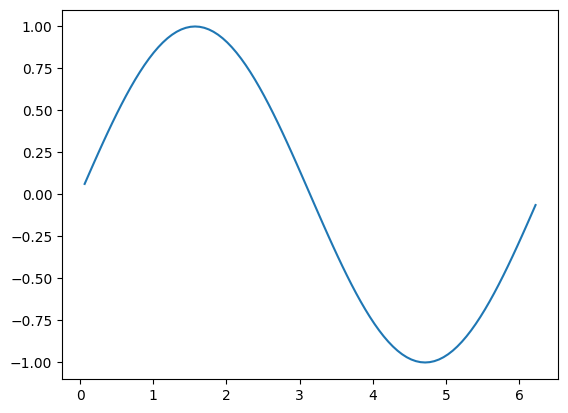

In [7]:
import HPO

import pysgpp

import sys

import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import cross_val_score

import numpy as np
import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor

import sklearn.metrics

def to_standard(lower, upper, value):
    return (value-lower)/(upper-lower)


def from_standard(lower, upper, value):
    return value*(upper-lower)+lower

X = []
Y = []

num_samples = 100

for i in range(1, num_samples):
    X.append(2.0*math.pi/num_samples * float(i))
    Y.append(math.sin(2.0*math.pi/num_samples * float(i)))

plt.plot(X, Y)
plt.show()

X = torch.Tensor(X)
Y = torch.Tensor(Y)

X = X.reshape(-1, 1)

dataset = HPO.Dataset(X, Y)


## Hyperparameterspace & Model & Function

In [8]:
BUDGET = 300
VERBOSE = 2
CV = 1
SCORING = 'neg_mean_squared_error'

hyperparameterspace = {
    'loss': ["list", 'binary_crossentropy', 'categorical_crossentropy', 'binary_crossentropy', 'mean_squared_error', 'mean_absolute_error'],
    #'loss': ["list", 'mean_absolute_error', 'log_cosh'],
    'epochs': ["interval-int", 1, 400]
}

##################### Model for grid and random search #####################

# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_shape=(1,), activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation=None))
    # Compile model
    #model.compile(loss=loss,
    #              optimizer='adam', metrics=['mean_squared_error'])
    return model

##################### Blackbox function for bayesian optimization #####################

hyperparameterspace_special = {}
for key in hyperparameterspace.keys():
    liste = []
    for i in range(1, len(hyperparameterspace[key])):
        liste.append(hyperparameterspace[key][i])
    hyperparameterspace_special[key] = liste


#hyperparameterspace_special = {
#    'loss': ['binary_crossentropy', 'categorical_crossentropy', 'binary_crossentropy', 'mean_squared_error', 'mean_absolute_error'],
#    'epochs': [1, 400]
#}

def blackboxfunction(params):
    index = int(params[0]*(len(hyperparameterspace_special["loss"])-1))
    loss = hyperparameterspace_special["loss"][index]
    
    epochs = int(params[1])

    # Function to create model, required for KerasClassifier
    def create_model():
        # create model
        model = Sequential()
        model.add(Dense(10, input_shape=(1,), activation='relu'))
        model.add(Dense(20, activation='relu'))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(20, activation='relu'))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(1, activation=None))
        # Compile model
        model.compile(loss=loss, optimizer='adam', metrics=['mean_squared_error'])
        return model

    model = KerasRegressor(model=create_model, verbose=0)

    #scores = cross_val_score(model, dataset.get_X(), dataset.get_Y(), cv=CV, scoring=SCORING)

    #return -scores.mean()
    model.fit(dataset.get_X_train(), dataset.get_Y_train(), epochs=epochs)

    Y_predicted = model.predict(dataset.get_X_test())

    return -sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted)
    

##################### Function for sparse grid search #####################

class ExampleFunction(pysgpp.ScalarFunction):

    def __init__(self):
        super(ExampleFunction, self).__init__(2)


    def eval(self, x):
        index = int(x[0]*(len(hyperparameterspace_special["loss"])-1))
        loss = hyperparameterspace_special["loss"][index]
        epochs = int(from_standard(1, 400, x[1]))
        
        # Function to create model, required for KerasClassifier
        def create_model():
            # create model
            model = Sequential()
            model.add(Dense(10, input_shape=(1,), activation='relu'))
            model.add(Dense(20, activation='relu'))
            model.add(Dense(10, activation='relu'))
            model.add(Dense(20, activation='relu'))
            model.add(Dense(10, activation='relu'))
            model.add(Dense(1, activation=None))
            # Compile model
            model.compile(loss=loss, optimizer='adam', metrics=['mean_squared_error'])
            return model

        model = KerasRegressor(model=create_model, verbose=0)

        # scores = cross_val_score(model, dataset.get_X(), dataset.get_Y(), cv=CV, scoring=SCORING)

        # return -scores.mean()

        model.fit(dataset.get_X_train(), dataset.get_Y_train(), epochs=epochs)

        Y_predicted = model.predict(dataset.get_X_test())

        return sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted)

## Grid search

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_negative_likelihood_ratio', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'positive_likelihood_ratio', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weight

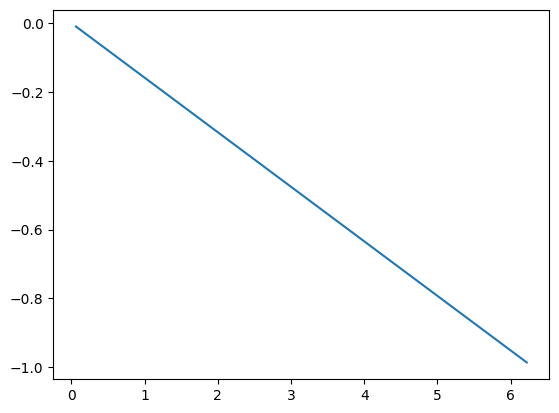

In [9]:
print(sklearn.metrics.get_scorer_names())

model = KerasRegressor(model=create_model, verbose=0)

optimization = HPO.Optimization(dataset, model, hyperparameterspace, type="grid_search", cv=CV, budget=BUDGET, verbosity=VERBOSE)
result = optimization.fit()

print("Best result:")
print(-result.best_score_)
print("Corresponding parameters:")
print(result.best_params_)

Y_predicted = result.predict(torch.Tensor(X).reshape(-1, 1))

plt.plot(X,Y_predicted)
plt.show()

## Random search

/home/maxi/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 85 is smaller than n_iter=300. Running 85 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 85 candidates, totalling 170 fits
[CV] END ................epochs=12, loss=binary_crossentropy; total time=   1.0s
[CV] END ................epochs=12, loss=binary_crossentropy; total time=   1.0s
[CV] END ...........epochs=12, loss=categorical_crossentropy; total time=   0.9s
[CV] END ...........epochs=12, loss=categorical_crossentropy; total time=   1.0s
[CV] END ................epochs=12, loss=binary_crossentropy; total time=   1.0s
[CV] END ................epochs=12, loss=binary_crossentropy; total time=   1.7s
[CV] END .................epochs=12, loss=mean_squared_error; total time=   1.2s
[CV] END .................epochs=12, loss=mean_squared_error; total time=   1.1s
[CV] END ................epochs=12, loss=mean_absolute_error; total time=   1.1s
[CV] END ................epochs=12, loss=mean_absolute_error; total time=   1.1s
[CV] END ................epochs=36, loss=binary_crossentropy; total time=   1.3s
[CV] END ................epochs=36, loss=binary

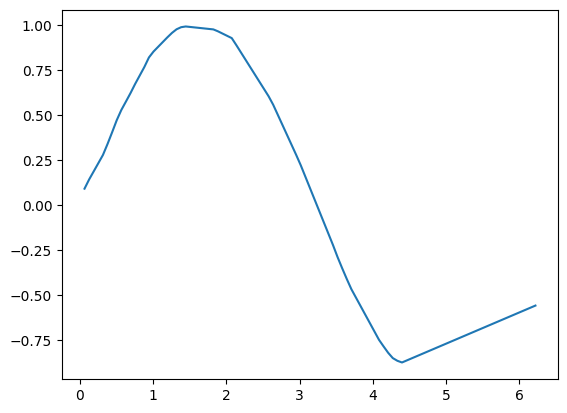

In [10]:
model = KerasRegressor(model=create_model, loss='binary_crossentropy', verbose=0)
optimization = HPO.Optimization(dataset, model, hyperparameterspace, type="random_search", cv=CV, budget=BUDGET, verbosity=VERBOSE)
result = optimization.fit()
print("Best result:")
print(-result.best_score_)
print("Corresponding parameters:")
print(result.best_params_)

Y_predicted = result.predict(torch.Tensor(X).reshape(-1, 1))

plt.plot(X,Y_predicted)
plt.show()

## Bayesian Optimization 

https://thuijskens.github.io/2016/12/29/bayesian-optimisation/ 

Progress: [####################] 100.0%
Current time per iteration: 3.885326579998946
Approx. time remaining: 0.0
Best MSE:
4.5174640417099
With Hyperparameters: 
loss: binary_crossentropy
epochs: 236.5938540462366
[array([  0.59210067, 236.59385405])]


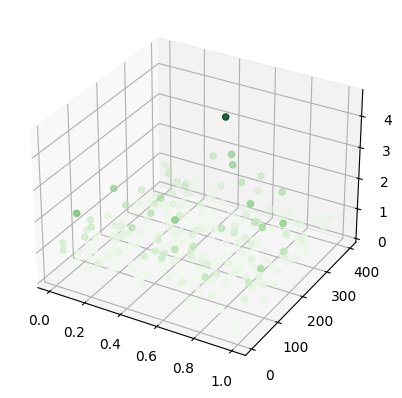

In [12]:
optimization = HPO.Optimization(dataset, blackboxfunction, hyperparameterspace, type="bayesian", budget=BUDGET, verbosity=VERBOSE)
result = optimization.fit()

fig = plt.figure()
ax = plt.axes(projection='3d')

x = [result[0][i][0] for i in range(len(result[0]))]
y = [result[0][i][1] for i in range(len(result[0]))]

ax.scatter3D(x, y, result[1], c=result[1], cmap='Greens')

index_best = 0
for i in range(len(result[1])):
    if result[1][i] == max(result[1]):
        index_best = i

best_score = result[1][index_best]
best_params = result[0][index_best]


print("Best MSE:")
print(best_score)
print("With Hyperparameters: ")
i = 0
for key in hyperparameterspace.keys():
    if hyperparameterspace[key][0] == "list":
        index = int(best_params[i]*(len(hyperparameterspace_special[key])-1))
        print(key + ": " + str(hyperparameterspace_special[key][index]))
    else:
        print(key + ": " + str(best_params[i]))
    i += 1


print([result[0][i] for i in range(len(result[0])) if result[1][i] == max(result[1])])
#print(result)

## Sparse grid search

Adaptive grid generation (Ritter-Novak)...
Done in 920753ms.
Solving linear system (automatic method)...
Done in 632ms.

Optimal hyperparameters so far:
loss: categorical_crossentropy
epochs: 200.5
Resulting loss:
0.20149846376067343
Optimizing (gradient descent)...
Done in 1ms.

Optimal hyperparameters after optimization:
loss: categorical_crossentropy
epochs: 1.0000368437119533
Resulting loss (Optimal value from optimization):
-8.133638759976458
Resulting loss (Optimal point evaluated):
0.36498430371284485


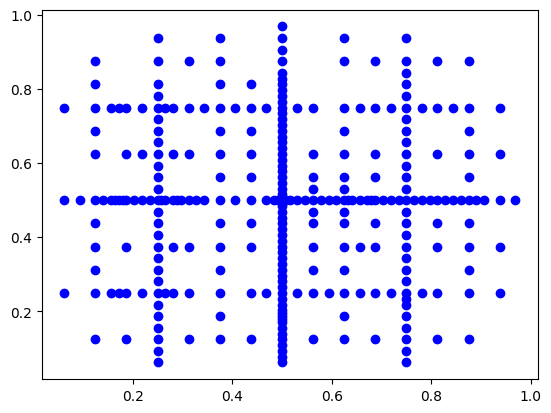

In [13]:
f = ExampleFunction()

optimization = HPO.Optimization(dataset, f, hyperparameterspace, type="sparse", budget=BUDGET, verbosity=VERBOSE)
result = optimization.fit()
